# 각 유저들의 Tension에 대한 유저들의 모달 주요도 시각화 및 클러스터링
- 101번 유저를 대상으로 MIL 모델 학습 및 모달 주요도 추출을 한 과정을 120번 유저까지 적용한 데이터를 사용하여 본 코드 구현

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

# 필요 라이브러리 로드

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
import os

In [ ]:
from scipy.stats import entropy

# 데이터 로드
- 101_test_모달 주요도 추출.ipynb와 같은 방식으로 101번부터 120번 사용자에서 모달 주요도를 추출하고 저장한 파일을 다시 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tension_path = '/content/drive/MyDrive/뭔데/tension_atts/'
tension_pickles = os.listdir(tension_path)

dict_df = {
    'user_name' : [],
    'values' : []
}
for p in tension_pickles:
    with open(tension_path + p,"rb") as fr:
        temp_data = pickle.load(fr)
        
    for td in temp_data:
        if len(p[:-2])==3:
            dict_df['user_name'].append(p[:-2])
            dict_df['values'].append(td)

df = pd.DataFrame(dict_df)
df.head()

,user_name,values
0,102,"[0.11042428, 0.03187075, 0.14383568, 0.1596450..."
1,102,"[0.1367307, 0.027114911, 0.14479896, 0.1546064..."
2,102,"[0.15886968, 0.023945192, 0.17665836, 0.181919..."
3,102,"[0.14446628, 0.024102071, 0.15392192, 0.164162..."
4,102,"[0.15460561, 0.020046772, 0.16677402, 0.172792..."


# 클루스터 평가 방식
- 한 클루스터에서 user를 얼마만큼 안 나누는가?
- agglomerative clustering 기법과 k means clustering 기법 사이의 성능 비교

In [ ]:
weight_arr = np.array(df['values'].to_list())

In [ ]:
group_sizes = [10, 20, 30]
group_labels = [[0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 
                [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 
                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                 1],
                [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 
                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                 1]]

# 각 그룹의 entropy 계산
group_entropies = [entropy(np.bincount(labels, minlength=2)) for labels in group_labels]

print(group_entropies)
print(sum(group_entropies))

[0.5004024235381879, 0.410116318288409, 0.38454291975622856]
1.2950616615828254


In [ ]:
agg_std_category_num = {}

entropy_nums = {}



for n_clusters in range(2, 11):
    group1_sizes = []
    group1_labels = []

    print(f'--------------n_cluster: {n_clusters}------------------------')
    agg_clustering1 = AgglomerativeClustering(n_clusters = n_clusters)
    idx = agg_clustering1.fit_predict(weight_arr)
    df['category'] = idx
    num_of_users = 0
    for user_name in sorted(df['user_name'].unique()):
        # category_num = {}
        # for i in range(n_clusters):
        #     category_num.setdefault(i, 0)
        group1_sizes.append(len(df[df['user_name'] == user_name]['category']))
        temp_arr = []
        for i in df[df['user_name'] == user_name]['category'].to_list():
            temp_arr.append(i)
        group1_labels.append(temp_arr)
    # print(group1_labels)
    print([entropy(np.bincount(labels, minlength=n_clusters)) for labels in group1_labels])
    entropy_nums.setdefault(n_clusters, sum([entropy(np.bincount(labels, minlength=n_clusters)) for labels in group1_labels]))

    #     print('-------------------------------------------')
    #     print(f'user_name: {user_name}')
    #     print(category_num)
    #     print(f'표본편차: {np.std(list(category_num.values()))}')
    #     category_std += np.std(list(category_num.values()))
    #     print('-------------------------------------------')
    # agg_std_category_num.setdefault(n_clusters, category_std)

--------------n_cluster: 2------------------------
[0.0, 0.0, 0.5455945739691843, 0.17768465741809233, 0.0, 0.013810551405765968, 0.0, 0.4750353248339567, 0.5898694717138787, 0.0, 0.68864291783917, 0.14549723734488965, 0.0, 0.3527180219814259, 0.08226061659787265, 0.0, 0.5652902240595894, 0.0, 0.0689522373440046, 0.42439072973274095]
--------------n_cluster: 3------------------------
[0.0, 0.0, 0.7064112487902295, 0.19724396627790156, 0.07184704290225172, 0.08448648548714065, 0.0, 1.023532027848815, 0.7635204523138099, 0.0, 0.7900952463085253, 0.14549723734488965, 0.02154825572686733, 0.9635187906692539, 0.09186586228616805, 0.06472093048965663, 0.7175661279708083, 0.0, 0.7107950664461349, 0.9883169718303555]
--------------n_cluster: 4------------------------
[0.0, 0.0, 1.2159182929896877, 0.22702514340349716, 0.07184704290225172, 0.08448648548714065, 0.0, 1.067281866365763, 1.0003490468549976, 0.0, 0.7900952463085253, 0.1651345000553993, 0.02154825572686733, 1.005312490887885, 0.18310

In [ ]:
agg_std_category_num = {}

entropy_nums2 = {}



for n_clusters in range(2, 11):
    group1_sizes = []
    group1_labels = []

    print(f'--------------n_cluster: {n_clusters}------------------------')
    agg_clustering1 = KMeans(n_clusters = n_clusters, max_iter=30000000, random_state = np.random.RandomState(seed=42) )
    idx = agg_clustering1.fit_predict(weight_arr)
    df['category'] = idx
    num_of_users = 0
    for user_name in sorted(df['user_name'].unique()):
        # category_num = {}
        # for i in range(n_clusters):
        #     category_num.setdefault(i, 0)
        group1_sizes.append(len(df[df['user_name'] == user_name]['category']))
        temp_arr = []
        for i in df[df['user_name'] == user_name]['category'].to_list():
            temp_arr.append(i)
        group1_labels.append(temp_arr)
    # print(group1_labels)
    print([entropy(np.bincount(labels, minlength=n_clusters)) for labels in group1_labels])
    entropy_nums2.setdefault(n_clusters, sum([entropy(np.bincount(labels, minlength=n_clusters)) for labels in group1_labels]))

    #     print('-------------------------------------------')
    #     print(f'user_name: {user_name}')
    #     print(category_num)
    #     print(f'표본편차: {np.std(list(category_num.values()))}')
    #     category_std += np.std(list(category_num.values()))
    #     print('-------------------------------------------')
    # agg_std_category_num.setdefault(n_clusters, category_std)

--------------n_cluster: 2------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.044819624275764414, 0.5844900840349817, 0.6404236673052692, 0.0, 0.15541638493373225, 0.4944096271731828, 0.592506561349586, 0.5996312285470695, 0.4858509535068388, 0.6699313071747194, 0.0, 0.0, 0.5519547219051436, 0.3834111178560703, 0.2967929867455098, 0.5033906046833972, 0.0, 0.011982117084677559, 0.21807363661087692]
--------------n_cluster: 3------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.528641552020973, 0.7051579678585889, 1.046363747707709, 0.6901856760188042, 0.03878524302844261, 1.0142061042587769, 1.0807249217180328, 0.9391054234204165, 0.6920817133419599, 0.711246687999436, 0.2514717761161135, 0.2938030203273905, 0.9130705256505693, 0.4981686502053682, 0.1938557976652743, 0.6230416616736253, 0.0, 0.5727192374257682, 0.829478193567625]
--------------n_cluster: 4------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5899265712747093, 0.6972356647928187, 1.1429330505659852, 0.8392227308801847, 0.2429541182650151, 1.2339445184121804, 1.3097451561332725, 0.8878159280123228, 0.47764491652663155, 0.961007241466362, 0.38976531445495355, 0.41032599907591916, 1.090440828997116, 0.768623018637414, 0.3089789113880685, 0.7247192580200719, 0.0, 0.6724800595834903, 1.151726833774858]
--------------n_cluster: 5------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5899265712747093, 0.9782092157014847, 0.6998446342957093, 0.6956600340450674, 0.1036796962300199, 0.9395165433140072, 1.4342379531182012, 0.8047620188570528, 1.0668002791844309, 1.0467183222772263, 0.43216018055350314, 0.12043238066795944, 1.292277682753929, 0.6633700386465247, 0.7848698953905139, 0.739383756793015, 0.5510085442321485, 1.0969307985943717, 1.4057283922343091]
--------------n_cluster: 6------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5899265712747093, 1.1455745996967708, 0.728501454904715, 0.6110140945528187, 0.10577973194326526, 0.9406618747234864, 1.5636309852751558, 0.9964374907188218, 1.191241900156327, 1.0999786445648618, 0.43045884812492247, 0.1140903805341927, 1.3690611905520165, 0.6573779336317301, 0.9748365544410493, 0.808514038872049, 0.6543872415783644, 1.2401072695196809, 1.5697336995381874]
--------------n_cluster: 7------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5188705134869669, 1.3159216673057235, 0.7841622578072194, 0.9248049701874369, 0.21359212600750233, 0.967029778350958, 1.6733966957445094, 0.9683504786856225, 0.032156056726384434, 1.2232457916570603, 0.5125409886042512, 0.16199440217482577, 1.6013516615554688, 0.9176551309780066, 1.020928625641703, 0.8824311310600759, 0.7595934020097987, 1.1482316312136784, 1.5592827715250117]
--------------n_cluster: 8------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5644220374140531, 1.4587011318914276, 0.8190714556291727, 0.9146037466782694, 0.22158724803196855, 0.9783348737279669, 1.701526381881455, 0.9811906683626713, 0.0642856792886549, 1.3686898714561868, 0.4658447319701559, 0.1659341912643884, 1.6244150140236266, 1.0222924698530171, 1.0512465339188177, 0.829822440778907, 0.7595934020097987, 1.1456679186208616, 1.564170236849335]
--------------n_cluster: 9------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.5559575212704977, 1.517311066875187, 0.8313858131960894, 0.9732945045937956, 0.7030829222304866, 1.0482745714462374, 1.757267982542919, 1.0752994848530144, 0.08927952886911111, 1.4197120208250593, 0.5046380954860527, 0.15732316608115574, 1.533272630100261, 1.0317422652295871, 1.0903281564095508, 0.8430184170680945, 0.7541500533558879, 1.2330034869456306, 1.6618835363294018]
--------------n_cluster: 10------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.0, 0.0, 1.224115806901227, 0.9435735684153242, 0.9369206368308819, 0.7324442493057293, 1.1564582819854683, 1.8322744907903439, 1.132228903218542, 0.1685261376745333, 1.4616184181856913, 0.5261614951422316, 0.18941507289672424, 1.646570497428356, 0.8527424195364699, 1.0744825746567677, 0.8879315918614208, 0.7522772066982006, 1.266967121650551, 1.7962462113579927]


In [ ]:
std_category_num = {}
for n_clusters in range(2, 11):
    print(f'--------------n_cluster: {n_clusters}------------------------')
    kmeans_clustering1 = KMeans(n_clusters = n_clusters, max_iter=30000000, random_state = np.random.RandomState(seed=42) )
    idx = kmeans_clustering1.fit_predict(weight_arr)
    df['category'] = idx
    category_std = 0
    for user_name in sorted(df['user_name'].unique()):
        category_num = {}
        for i in range(n_clusters):
            category_num.setdefault(i, 0)        
        for i in df[df['user_name'] == user_name]['category'].to_list():
            category_num[i] += 1
        print('-------------------------------------------')
        print(f'user_name: {user_name}')
        print(category_num)
        print(f'표본편차: {np.std(list(category_num.values()))}')
        category_std += np.std(list(category_num.values()))
        print('-------------------------------------------')
    std_category_num.setdefault(n_clusters, category_std)

--------------n_cluster: 2------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 369, 1: 0}
표본편차: 184.5
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 1, 1: 130}
표본편차: 64.5
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 83, 1: 223}
표본편차: 70.0
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 230, 1: 118}
표본편차: 56.0
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 442, 1: 0}
표본편차: 221.0
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 507, 1: 19}
표본편차: 244.0
-------------------------------------------
-------------------------------------------
user_name: 107
{0: 263, 1: 64}
표본편차: 99.5
-------------------------------------------
-------------------------------------------
user_name: 108
{0: 549, 1: 213}
표본편차: 168.0
-

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 369, 1: 0, 2: 0}
표본편차: 173.9482681718907
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 102, 2: 29}
표본편차: 42.913349386357105
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 4, 1: 198, 2: 104}
표본편차: 79.21279357948858
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 169, 1: 99, 2: 80}
표본편차: 38.27096375408734
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 238, 1: 0, 2: 204}
표본편차: 105.10100961561797
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 2, 1: 1, 2: 523}
표본편차: 245.83779656965325
-------------------------------------------
-------------------------------------------
user_name: 107
{0: 125, 1: 51, 2: 151}
표본편차: 42.3635063075

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 369, 2: 0, 3: 0}
표본편차: 159.78168699822893
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 31, 1: 0, 2: 99, 3: 1}
표본편차: 40.226701331329664
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 91, 1: 3, 2: 210, 3: 2}
표본편차: 85.1249082231517
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 48, 1: 155, 2: 129, 3: 16}
표본편차: 56.89903338370521
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 0, 1: 244, 2: 177, 3: 21}
표본편차: 103.03518816404423
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 0, 1: 1, 2: 32, 3: 493}
표본편차: 209.1082255675276
-------------------------------------------
-------------------------------------------
user_name: 107
{0: 17

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 369, 2: 0, 3: 0, 4: 0}
표본편차: 147.6
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 31, 1: 0, 2: 0, 3: 99, 4: 1}
표본편차: 38.29046878793729
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 77, 1: 29, 2: 0, 3: 190, 4: 10}
표본편차: 69.6316020209215
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 44, 1: 274, 2: 0, 3: 25, 4: 5}
표본편차: 103.38394459489345
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 0, 1: 320, 2: 108, 3: 1, 4: 13}
표본편차: 122.60603574049689
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 0, 1: 2, 2: 0, 3: 8, 4: 516}
표본편차: 205.42093369469433
-------------------------------------------
------------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 369, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
표본편차: 137.51818061623706
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 31, 2: 0, 3: 1, 4: 99, 5: 0}
표본편차: 36.29240814397536
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 9, 1: 77, 2: 38, 3: 10, 4: 172, 5: 0}
표본편차: 59.90548110704618
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 77, 1: 7, 2: 257, 3: 4, 4: 3, 5: 0}
표본편차: 92.97669959009443
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 344, 1: 0, 2: 1, 3: 7, 4: 1, 5: 89}
표본편차: 124.99822220958004
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 3, 1: 0, 2: 0, 3: 516, 4: 7, 5: 0}
표본편차: 191.57302060108105
----------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 369}
표본편차: 129.12310215528467
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 103, 1: 28, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
표본편차: 35.739990749516295
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 51, 1: 68, 2: 0, 3: 146, 4: 3, 5: 36, 6: 2}
표본편차: 48.5113073290703
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 52, 1: 6, 2: 0, 3: 3, 4: 0, 5: 264, 6: 23}
표본편차: 89.1815392263192
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 284, 1: 0, 2: 103, 3: 1, 4: 2, 5: 1, 6: 51}
표본편차: 97.0735046556085
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 15, 1: 0, 2: 0, 3: 7, 4: 503, 5: 0, 6: 1}
표본편차: 174.74833215752514
--

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 369, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
표본편차: 122.03527922285424
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 0, 2: 0, 3: 0, 4: 98, 5: 0, 6: 33, 7: 0}
표본편차: 32.6876792538106
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 33, 1: 3, 2: 0, 3: 149, 4: 51, 5: 26, 6: 41, 7: 3}
표본편차: 45.499313181629454
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 258, 1: 23, 2: 0, 3: 4, 4: 57, 5: 0, 6: 6, 7: 0}
표본편차: 83.10836299675262
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 1, 1: 49, 2: 102, 3: 1, 4: 287, 5: 0, 6: 0, 7: 2}
표본편차: 94.04752787819571
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 0, 1: 1, 2: 0, 3: 8, 4: 15, 5: 0, 6: 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 369, 7: 0, 8: 0}
표본편차: 115.96551211459379
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 0, 2: 32, 3: 0, 4: 0, 5: 0, 6: 0, 7: 99, 8: 0}
표본편차: 31.47877984050388
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 151, 1: 5, 2: 33, 3: 38, 4: 8, 5: 0, 6: 1, 7: 44, 8: 26}
표본편차: 44.261847127194216
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 5, 1: 0, 2: 4, 3: 265, 4: 5, 5: 0, 6: 25, 7: 44, 8: 0}
표본편차: 81.2376486338419
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 1, 1: 0, 2: 0, 3: 1, 4: 7, 5: 94, 6: 57, 7: 282, 8: 0}
표본편차: 88.16202816335695
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 1, 1: 14

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------------------------
user_name: 101
{0: 0, 1: 0, 2: 0, 3: 369, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
표본편차: 110.7
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 0, 2: 131, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
표본편차: 39.300000000000004
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 10, 1: 188, 2: 0, 3: 1, 4: 43, 5: 40, 6: 0, 7: 18, 8: 1, 9: 5}
표본편차: 54.662967354507934
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 225, 1: 13, 2: 0, 3: 16, 4: 91, 5: 2, 6: 0, 7: 0, 8: 1, 9: 0}
표본편차: 68.72088474401359
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 1, 1: 0, 2: 1, 3: 44, 4: 289, 5: 0, 6: 100, 7: 0, 8: 7, 9: 0}
표본편차: 87.16168883173387
-------------------------------------------
-------------------------------------------
user_n

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

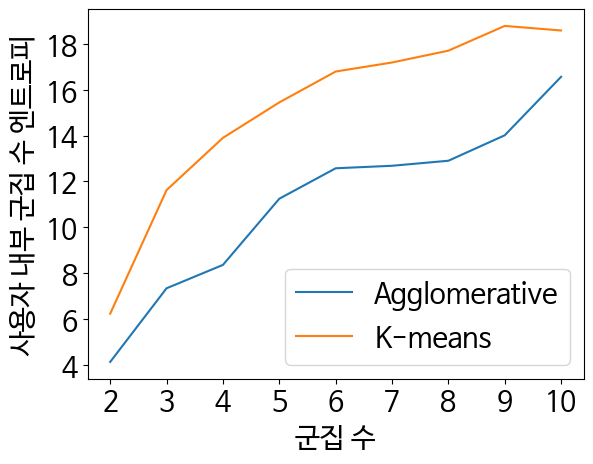

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

plt.plot(list(entropy_nums), list(entropy_nums.values()), label = 'Agglomerative')
plt.plot(list(entropy_nums2), list(entropy_nums2.values()), label = 'K-means')
plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('군집 수', fontsize=20)

plt.ylabel('사용자 내부 군집 수 엔트로피', fontsize=20)
plt.ylabel

# 실루엣 계수가 가장 높은 군집 개수 선정
- agglomerative 방식이 kmeans 방식보다 성능이 좋았으므로, agglomerative clustering을 대상으로 평가
- 실루엣 계수를 사용한 결과 군집은 5개를 사용하는 것으로 결정

In [ ]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.cm as cm
    import math
    clusters_range = range(3,10)
    results = []

    for i in clusters_range:
        clusterer = AgglomerativeClustering(n_clusters = i)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.set(font_scale=2)
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut,annot_kws={"size": 20})
    plt.tight_layout()
    # plt.legend(fontsize=20)
    plt.show()

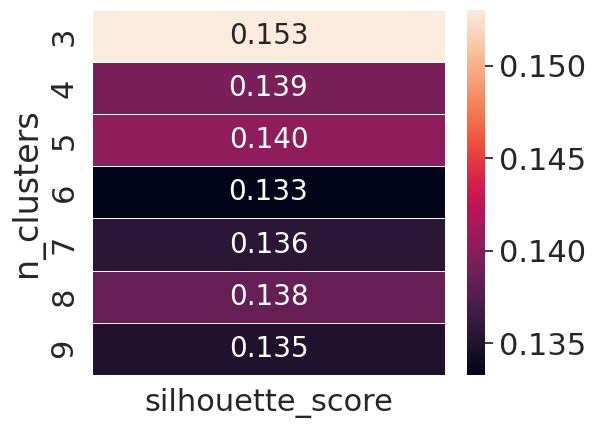

In [ ]:
visualize_silhouette_layer(weight_arr)

In [ ]:
weight_arr = np.array(df['values'].to_list())

kmeans_clustering1 = AgglomerativeClustering(n_clusters = 5)
idx = kmeans_clustering1.fit_predict(weight_arr)

df['category'] = idx

# cluster_center = kmeans_clustering1.cluster_centers_

print(df.category.value_counts())

4    3282
0    2490
2    2261
3    1966
1    1746
Name: category, dtype: int64


# 모달 주요도 2차원으로 시각화

In [ ]:
X = weight_arr
tsne_filepath1 = 'tsne_tension4.pkl'


tsne1 = TSNE(random_state=42)
tsne_points1 = tsne1.fit_transform(X)
        
tsne_df = pd.DataFrame(tsne_points1, index=range(len(X)), columns=['x_coord', 'y_coord'])

In [ ]:
tsne_df['category'] = df['category']
tsne_df['labels'] = df['user_name']

# 각 유저별 모달 주요도 2차원 시각화

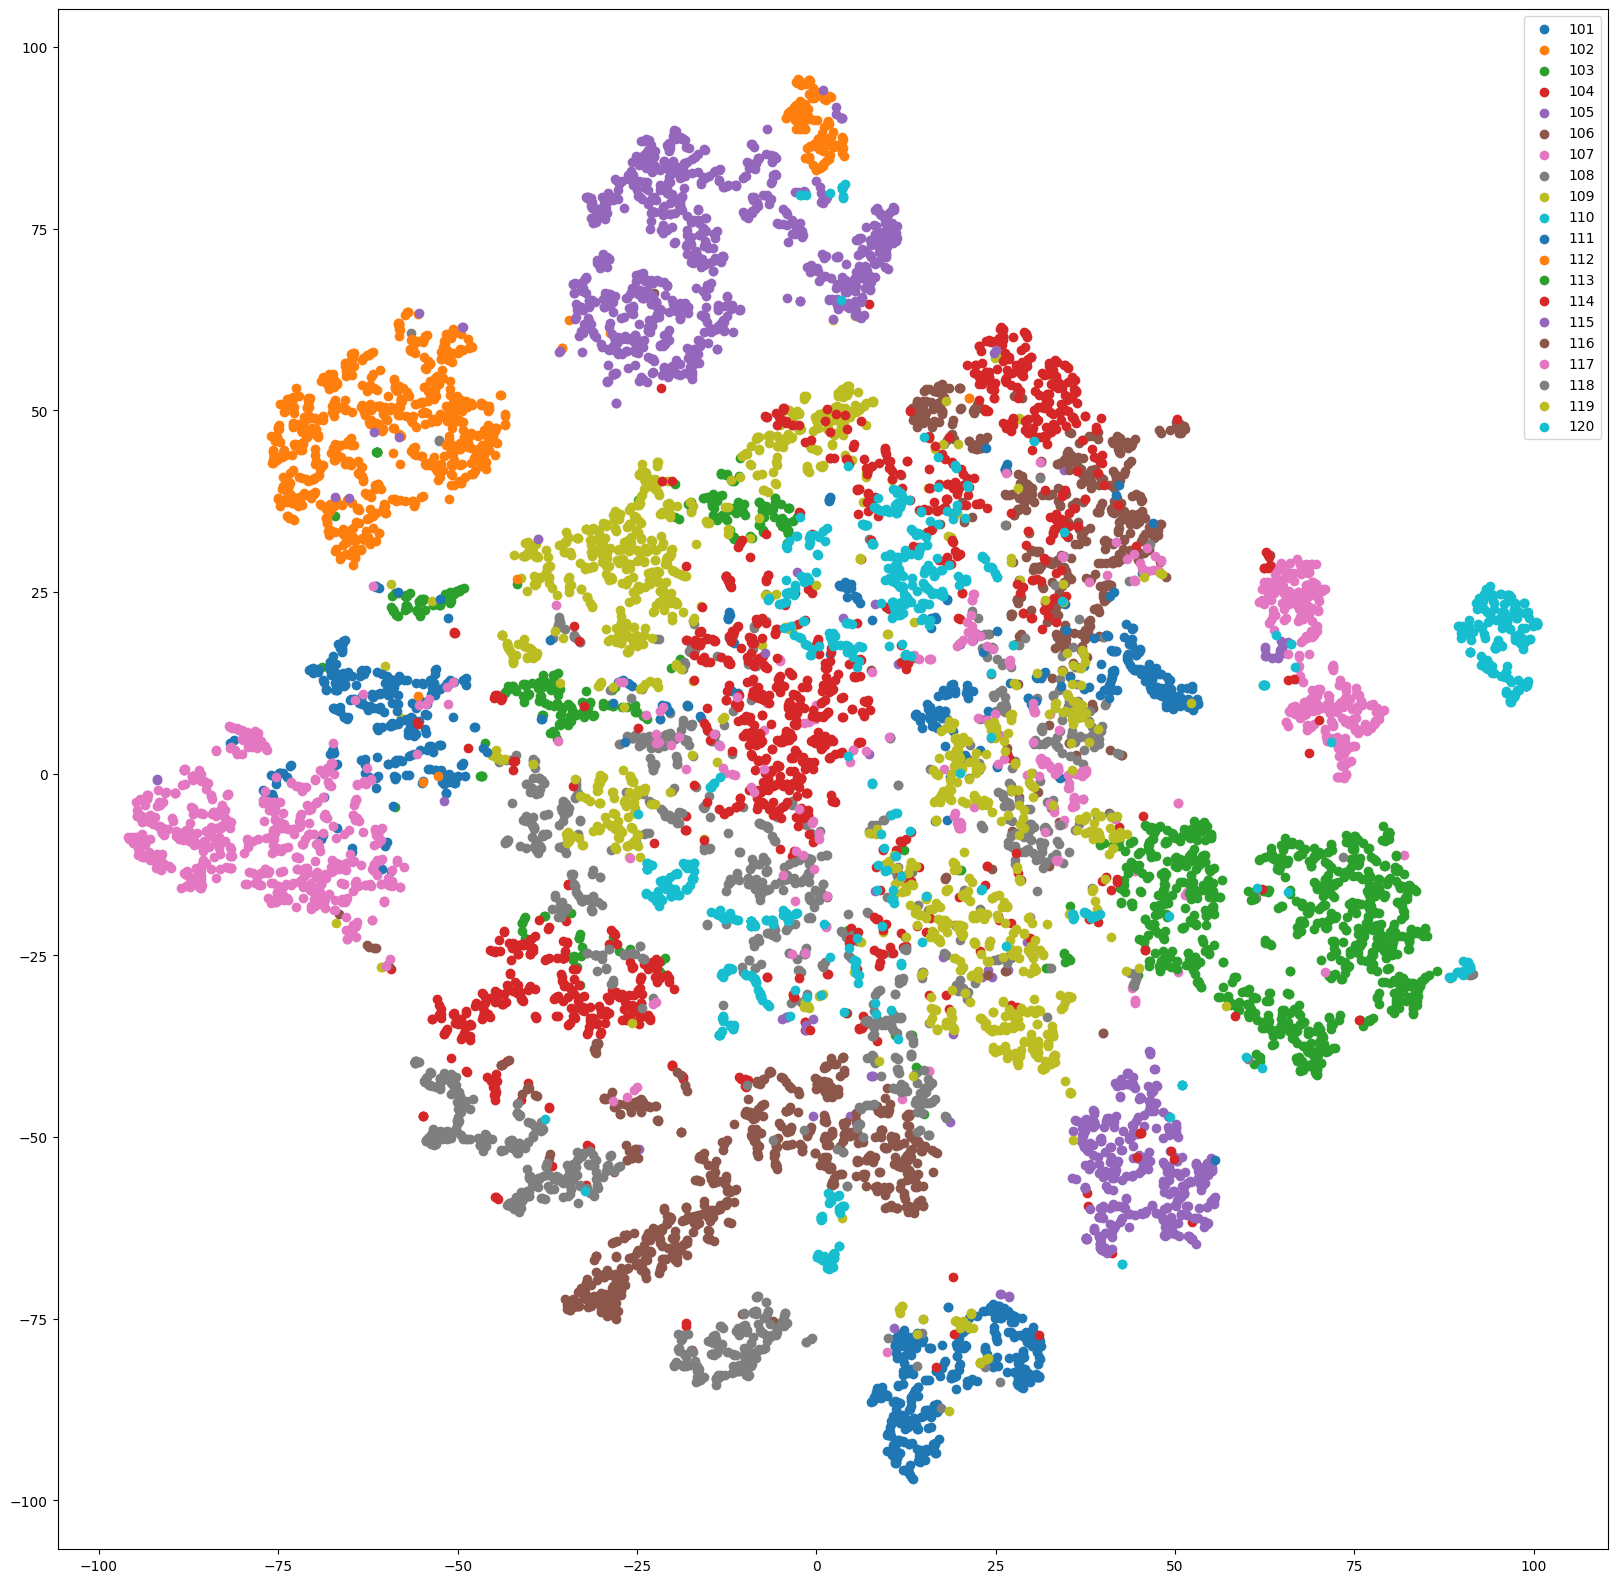

In [ ]:
plt.figure(figsize=(20,20))

cluster0x = tsne_df[tsne_df['labels']=='101']['x_coord']
cluster1x = tsne_df[tsne_df['labels']=='102']['x_coord']
cluster2x = tsne_df[tsne_df['labels']=='103']['x_coord']
cluster3x = tsne_df[tsne_df['labels']=='104']['x_coord']
cluster4x = tsne_df[tsne_df['labels']=='105']['x_coord']
cluster5x = tsne_df[tsne_df['labels']=='106']['x_coord']
cluster6x = tsne_df[tsne_df['labels']=='107']['x_coord']
cluster7x = tsne_df[tsne_df['labels']=='108']['x_coord']
cluster8x = tsne_df[tsne_df['labels']=='109']['x_coord']
cluster9x = tsne_df[tsne_df['labels']=='110']['x_coord']
cluster10x = tsne_df[tsne_df['labels']=='111']['x_coord']
cluster11x = tsne_df[tsne_df['labels']=='112']['x_coord']
cluster12x = tsne_df[tsne_df['labels']=='113']['x_coord']
cluster13x = tsne_df[tsne_df['labels']=='114']['x_coord']
cluster14x = tsne_df[tsne_df['labels']=='115']['x_coord']
cluster15x = tsne_df[tsne_df['labels']=='116']['x_coord']
cluster16x = tsne_df[tsne_df['labels']=='117']['x_coord']
cluster17x = tsne_df[tsne_df['labels']=='118']['x_coord']
cluster18x = tsne_df[tsne_df['labels']=='119']['x_coord']
cluster19x = tsne_df[tsne_df['labels']=='120']['x_coord']

cluster0y = tsne_df[tsne_df['labels']=='101']['y_coord']
cluster1y = tsne_df[tsne_df['labels']=='102']['y_coord']
cluster2y = tsne_df[tsne_df['labels']=='103']['y_coord']
cluster3y = tsne_df[tsne_df['labels']=='104']['y_coord']
cluster4y = tsne_df[tsne_df['labels']=='105']['y_coord']
cluster5y = tsne_df[tsne_df['labels']=='106']['y_coord']
cluster6y = tsne_df[tsne_df['labels']=='107']['y_coord']
cluster7y = tsne_df[tsne_df['labels']=='108']['y_coord']
cluster8y = tsne_df[tsne_df['labels']=='109']['y_coord']
cluster9y = tsne_df[tsne_df['labels']=='110']['y_coord']
cluster10y = tsne_df[tsne_df['labels']=='111']['y_coord']
cluster11y = tsne_df[tsne_df['labels']=='112']['y_coord']
cluster12y = tsne_df[tsne_df['labels']=='113']['y_coord']
cluster13y = tsne_df[tsne_df['labels']=='114']['y_coord']
cluster14y = tsne_df[tsne_df['labels']=='115']['y_coord']
cluster15y = tsne_df[tsne_df['labels']=='116']['y_coord']
cluster16y = tsne_df[tsne_df['labels']=='117']['y_coord']
cluster17y = tsne_df[tsne_df['labels']=='118']['y_coord']
cluster18y = tsne_df[tsne_df['labels']=='119']['y_coord']
cluster19y = tsne_df[tsne_df['labels']=='120']['y_coord']


plt.scatter(cluster0x, cluster0y, label='101')
plt.scatter(cluster1x, cluster1y, label='102')
plt.scatter(cluster2x, cluster2y, label='103')
plt.scatter(cluster3x, cluster3y, label='104')
plt.scatter(cluster4x, cluster4y, label='105')
plt.scatter(cluster5x, cluster5y, label='106')
plt.scatter(cluster6x, cluster6y, label='107')
plt.scatter(cluster7x, cluster7y, label='108')
plt.scatter(cluster8x, cluster8y, label='109')
plt.scatter(cluster9x, cluster9y, label='110')
plt.scatter(cluster10x, cluster10y, label='111')
plt.scatter(cluster11x, cluster11y, label='112')
plt.scatter(cluster12x, cluster12y, label='113')
plt.scatter(cluster13x, cluster13y, label='114')
plt.scatter(cluster14x, cluster14y, label='115')
plt.scatter(cluster15x, cluster15y, label='116')
plt.scatter(cluster16x, cluster16y, label='117')
plt.scatter(cluster17x, cluster17y, label='118')
plt.scatter(cluster18x, cluster18y, label='119')
plt.scatter(cluster19x, cluster19y, label='120')

plt.legend(loc='best')
plt.show()

# 각 군집에 사용자 할당
- 특정 군집에 한 사용자의 데이터가 많이 있을 경우, 사용자를 특정 그룹으로 설정

In [ ]:
weight_arr = np.array(df['values'].to_list())

agg_clustering1 = AgglomerativeClustering(n_clusters = 5)
idx = agg_clustering1.fit_predict(weight_arr)

df['agg_category'] = idx

In [ ]:
agg_user_cluster_number = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
}

for user_name in sorted(df['user_name'].unique()):
    category_num = {}
    
    for i in range(5):
        category_num.setdefault(i, 0) 
        
    for i in df[df['user_name'] == user_name]['agg_category'].to_list():
        category_num[i] += 1
    
    agg_user_cluster_number[max(category_num,key=category_num.get)].append(user_name)
    print('-------------------------------------------')
    print(f'user_name: {user_name}')
    print(category_num)
    print('-------------------------------------------')

-------------------------------------------
user_name: 101
{0: 369, 1: 0, 2: 0, 3: 0, 4: 0}
-------------------------------------------
-------------------------------------------
user_name: 102
{0: 0, 1: 0, 2: 0, 3: 131, 4: 0}
-------------------------------------------
-------------------------------------------
user_name: 103
{0: 41, 1: 90, 2: 31, 3: 144, 4: 0}
-------------------------------------------
-------------------------------------------
user_name: 104
{0: 317, 1: 7, 2: 1, 3: 8, 4: 15}
-------------------------------------------
-------------------------------------------
user_name: 105
{0: 243, 1: 0, 2: 6, 3: 0, 4: 193}
-------------------------------------------
-------------------------------------------
user_name: 106
{0: 1, 1: 0, 2: 518, 3: 1, 4: 6}
-------------------------------------------
-------------------------------------------
user_name: 107
{0: 0, 1: 0, 2: 0, 3: 0, 4: 327}
-------------------------------------------
------------------------------------------

In [ ]:
agg_user_cluster_number

{0: ['101', '104', '105', '108', '110', '118', '120'],
 1: ['112', '117'],
 2: ['106', '111'],
 3: ['102', '103', '109', '115'],
 4: ['107', '113', '114', '116', '119']}

# 각 그룹 별 평균 모달 주요도 추출

In [ ]:
k = {0: ['101', '104', '105', '108', '110', '118', '120'],
 1: ['112', '117'],
 2: ['106', '111'],
 3: ['102', '103', '109', '115'],
 4: ['107', '113', '114', '116', '119']}

In [ ]:
def get_top_n(list_a, num):
    '''
    list_a: [int, int, ...] 
    num: int, 추출하고 싶은 개수 
    '''
    tmp = list_a.copy()
    tmp.sort()
   
    top_num = tmp[-num:]    
    top_idx = [list_a.index(x) for x in top_num]
    
    return top_idx

In [ ]:
pos = []
users = []
groups = []
for i in range(len(k)):
    print(i)
    a = []
    u = [0 for i in range(9)]
    for j in range(len(k[i])):
        users.append(k[i][j])
        jjj = np.array([0 for kk in range(9)])
        print(k[i][j])
        for l in df[df['user_name']==k[i][j]]['values'].to_list():
            jjj = jjj + np.array(l)
        print(jjj)
        pos.append(jjj)
        print(get_top_n(list(jjj), 3))
        a += get_top_n(list(jjj), 3)
        u += np.array(jjj)

        print()
    print(set(a))
    print(u)
    groups.append(u)
    print()

0
101
[32.28816957  6.43671931 37.80692796 77.04143907 22.82117675 54.69991036
 76.60857201 35.9612008  25.3358842 ]
[5, 6, 3]

104
[54.91657268 10.11003657 19.66365948 40.62418927  7.57869808 77.8664084
 58.7895299  31.14419622 47.30670809]
[0, 6, 5]

105
[50.21667816  9.31154635 75.73506647 67.23493419  7.85527973 97.77475838
 60.97025571 44.44566674 28.45581331]
[3, 2, 5]

108
[117.73981184  15.40656275  57.56846341  91.11040451  46.51982507
 129.72615837 107.82397275 111.03068481  85.0741163 ]
[7, 0, 5]

110
[23.62238746  3.35209702 19.1202551  40.300707    3.85249576 46.5298128
  4.4050698  24.35620537 29.46096943]
[8, 3, 5]

118
[116.87123201  14.00421631  55.79548611  69.46692272  25.22146438
  97.31419896 135.53795695  61.37930707  70.40921527]
[5, 0, 6]

120
[108.80301775  20.09111976  72.38178273  80.77538458  41.52475246
 123.74311437  85.86175901  87.74958168  48.06948781]
[7, 0, 5]

{0, 2, 3, 5, 6, 7, 8}
[504.45786947  78.71229806 338.07164126 466.55398135 155.37369223
 62

In [ ]:
groups

[array([504.45786947,  78.71229806, 338.07164126, 466.55398135,
        155.37369223, 627.65436164, 529.99711614, 396.0668427 ,
        334.11219442]),
 array([296.39378505,  40.96569846, 113.7687168 , 189.05001844,
         89.11939717, 186.05408432,  80.52467241, 218.737553  ,
        310.38607416]),
 array([187.11639189,  24.61406355,  83.75537533, 157.70479251,
         45.76228835, 188.54191528, 100.33055105, 237.49196644,
        101.682657  ]),
 array([446.1572742 ,  55.09182285, 192.44237548, 226.34120042,
        174.77700769, 375.22149514, 134.55827766, 247.21265473,
        223.1978912 ]),
 array([562.64361083,  98.60084999, 456.01994156, 370.61425556,
        158.65350447, 531.37863776, 552.05539682, 560.20893215,
        296.82487337])]

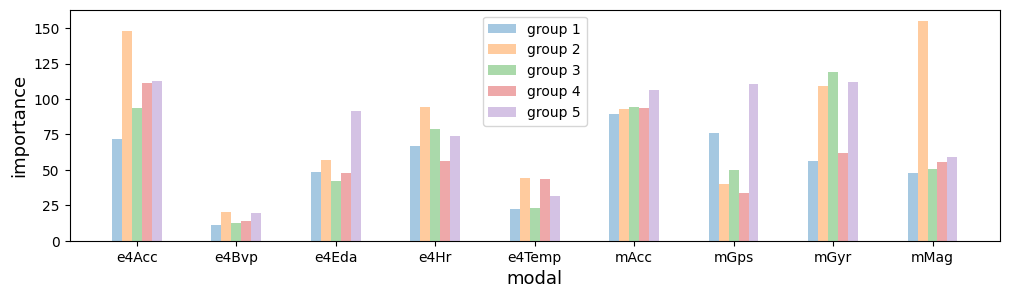

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12,3))
bar_width = 0.1

index = np.arange(9)

b1 = plt.bar(index-2*bar_width, groups[0]/7, bar_width, alpha=0.4, label='group 1')
b2 = plt.bar(index-bar_width, groups[1]/2, bar_width, alpha=0.4, label='group 2')
b3 = plt.bar(index, groups[2]/2, bar_width, alpha=0.4, label='group 3')
b2 = plt.bar(index+bar_width, groups[3]/4, bar_width, alpha=0.4, label='group 4')
b3 = plt.bar(index+2 * bar_width, groups[4]/5, bar_width, alpha=0.4, label='group 5')

sensors = ['e4Acc', 'e4Bvp', 'e4Eda', 'e4Hr', 'e4Temp', 'mAcc', 'mGps', 'mGyr', 'mMag']
plt.xticks(np.arange(9), (sensors))

plt.xlabel('modal', size = 13)
plt.ylabel('importance', size = 13)
plt.legend()
plt.show()